## End-to-end Multi-class Dog Breed Classification

image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem Definition

Identifying the breed of a dog given an image of a dog.

## 2. Data

data source: https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

* We are dealing with images, there are 120 breeds of dogs.
* There are around 10.000+ images in the training set (with labels).
* There are around 10.000+ images in the test set (without labels).

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
print(f"TF version {tf.__version__}")
print(f"TF Hub version {hub.__version__}")

TF version 2.8.0
TF Hub version 0.12.0


In [3]:
# check for GPU 
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")


GPU available


## Load and Prepare Data

In [4]:
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Data/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())


                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


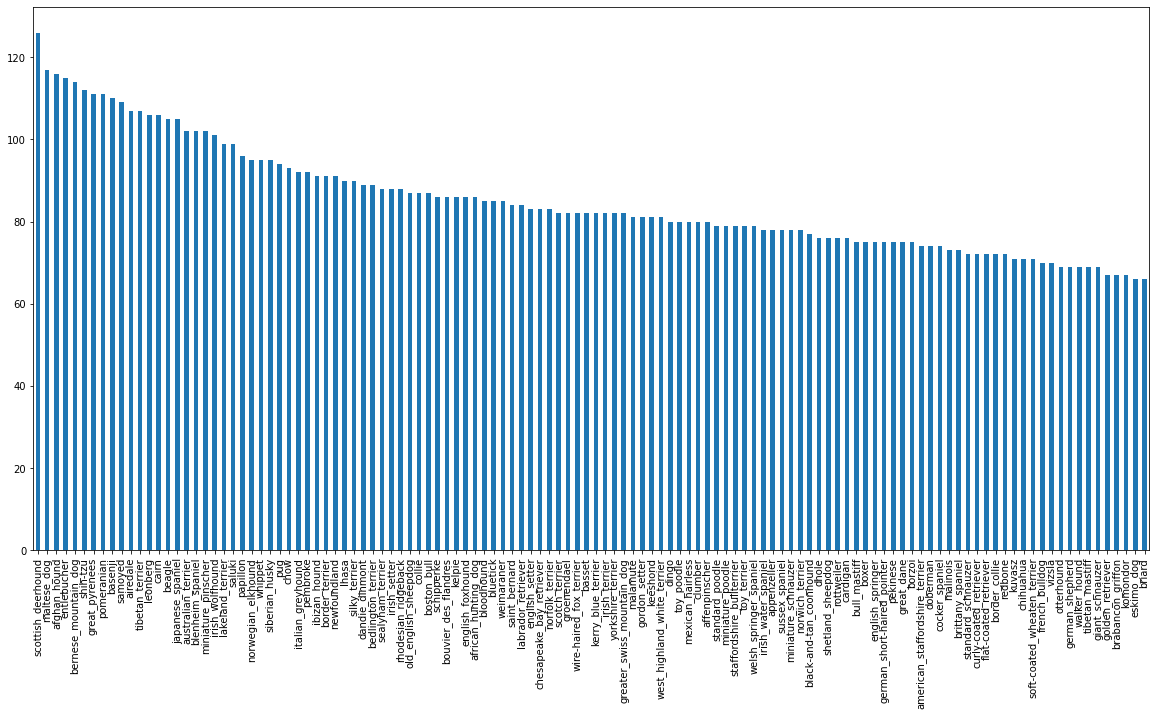

In [5]:
# how many images for each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10));


In [6]:
labels_csv["breed"].value_counts().median()

82.0

### Getting images and their labels

In [7]:
# create pathnames from images ID's
filenames = ["/content/drive/MyDrive/Data/train/" + fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['/content/drive/MyDrive/Data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/Data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [8]:
# check the amount of data
import os
if len(os.listdir("/content/drive/MyDrive/Data/train/")) == len(filenames):
  print("right amount of data")
else:
  print("error")

right amount of data


In [9]:
# prepare labels
import numpy as np
labels = labels_csv["breed"]
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [10]:
if len(labels) == len(filenames):
  print("right amount of data")
else:
  print("error")

right amount of data


In [11]:
# find the unique labels values
unique_breeds = np.unique(labels)



In [12]:
# turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
len(boolean_labels)

10222

### Creating  validation set

In [13]:
# setup X and y 
X = filenames
y = boolean_labels

In [32]:
num_images = 1000 #@param {type:"slider", min:1000, max:10000, step:100}

In [15]:
# split our data into train and validation
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:num_images],
                                                  y[:num_images],
                                                  test_size=0.2,
                                                  random_state=2)

In [16]:
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

## Turn images into *tensors*

In [17]:
img_size = 224
def process_image(image_path):
  """
    Takes an image and turns the image into a Tensor.
  """  
  # read the file and save it to a var
  image = tf.io.read_file(image_path)

  # turn the var into numerical Tensor with 3 colour channels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)

  # convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # resize var to be a shape of (224, 224)
  image = tf.image.resize(image, size=[img_size, img_size])

  # return the modified var
  return image

## Turn data into batches

In [18]:
def get_image_label(image_path, label):
  """
    Takes an image file path name and the associated label,
    processes the image and returns a tuple of (image, label).   
  """
  image = process_image(image_path)
  return image, label

In [19]:
batch_size = 32

def create_data_batches(X, y=None, batch_size=batch_size, valid_data=False, test_data=False):
  """
    Create batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
  """
  
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch
  
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data = data.map(get_image_label)
    data_batch = data.batch(batch_size)
  
  return data_batch 


In [20]:
# create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [21]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

In [22]:
import matplotlib.pyplot as plt

def show_images(images, labels):
  """
    Displays a plot of 25 images and their labels from a data batch.
  """

  plt.figure(figsize=(10,10))

  for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

    

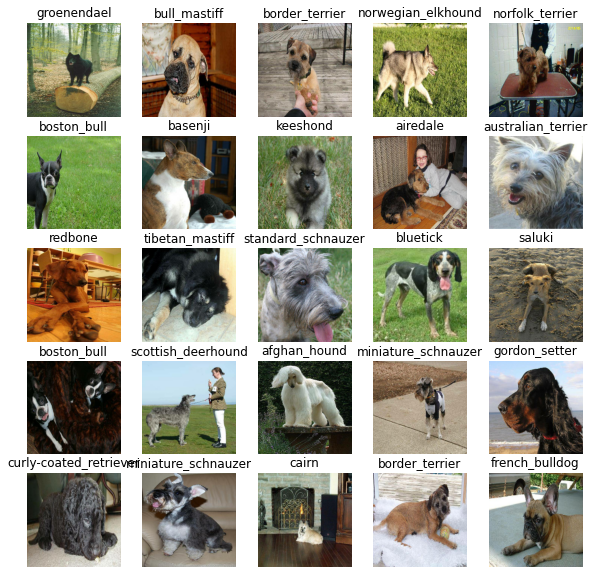

In [23]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_images(train_images, train_labels)

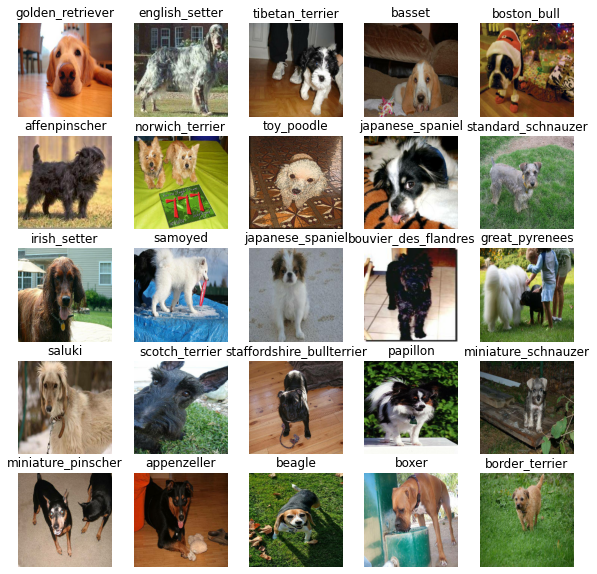

In [24]:
val_images, val_labels = next(val_data.as_numpy_iterator())
show_images(val_images, val_labels)

## Building a model

In [25]:
input_shape = [None, img_size, img_size, 3] # batch, height, width, colour channels

output_shape = len(unique_breeds)

model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [26]:
def create_model(input_shape=input_shape, output_shape=output_shape, model_url=model_url):
  print(f"Building model with: {model_url}")

  # define the layers in a keras model in sequential fashion
  model = tf.keras.Sequential([
    hub.KerasLayer(model_url), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=output_shape,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # compiles the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # builds the model 
  model.build(input_shape)

  return model


In [27]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

In [28]:
# callback that helps track our model's progress
%load_ext tensorboard

import datetime 

def create_tensorboard_callback():
  # create a  directory for storing tensorboard logs
  log_dir = os.path.join("/content/drive/MyDrive/Data/logs",
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  return tf.keras.callbacks.TensorBoard(log_dir)



In [29]:
# callback for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)


## Training a model

In [30]:
# subset 1000 images
num_epochs = 100 #@param {type:"slider", min:10, max:100, step:10}



In [31]:
def train_model():
  """
    Trains a given model and returns the trained version.
  """
  # create a model
  model = create_model()

  # create new TensorBoard session
  tensorboard = create_tensorboard_callback()

  # fit the model to the data
  model.fit(x=train_data,
            epochs=num_epochs,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  return model






In [33]:
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 104s 4s/step - loss: 4.6197 - accuracy: 0.1025 - val_loss: 3.3319 - val_accuracy: 0.2700
Epoch 2/100
25/25 [==============================] - 5s 194ms/step - loss: 1.6655 - accuracy: 0.6837 - val_loss: 2.1259 - val_accuracy: 0.4850
Epoch 3/100
25/25 [==============================] - 5s 199ms/step - loss: 0.5623 - accuracy: 0.9400 - val_loss: 1.6701 - val_accuracy: 0.5650
Epoch 4/100
25/25 [==============================] - 5s 189ms/step - loss: 0.2513 - accuracy: 0.9850 - val_loss: 1.4989 - val_accuracy: 0.6100
Epoch 5/100
25/25 [==============================] - 5s 191ms/step - loss: 0.1438 - accuracy: 0.9987 - val_loss: 1.4349 - val_accuracy: 0.6350
Epoch 6/100
25/25 [==============================] - 4s 176ms/step - loss: 0.0963 - accuracy: 1.0000 - val_loss: 1.3963 - val_accuracy: 0.6350
Epoch 7/100
25/25 [==============================]

The model is overfitting because it's performing better on the training dataset than the validation dataset. 

In [34]:
# checking the logs
%tensorboard --logdir /content/drive/MyDrive/Data/logs


## Make and evaluate  predictions using the trained model


In [35]:
# make predictions on validation data
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 3s 214ms/step


array([[7.6102289e-05, 3.4324324e-04, 1.1668255e-04, ..., 1.3036880e-04,
        2.3924157e-03, 9.0211606e-06],
       [7.6240585e-06, 2.8707489e-04, 2.7575789e-03, ..., 3.2453074e-05,
        4.1127638e-05, 5.2442061e-05],
       [1.7186472e-02, 1.0555933e-03, 2.2753708e-04, ..., 5.0485978e-04,
        1.2381877e-02, 8.1103733e-03],
       ...,
       [5.9198304e-05, 2.3096947e-03, 5.7486896e-03, ..., 4.9110316e-03,
        5.0789369e-03, 1.4533223e-04],
       [7.9517165e-05, 1.9057738e-04, 1.8583701e-04, ..., 3.2782442e-05,
        8.6767926e-05, 2.7830977e-04],
       [2.9402772e-05, 8.0469233e-04, 2.0097595e-04, ..., 2.9541677e-04,
        1.3890252e-02, 9.6593094e-06]], dtype=float32)

In [36]:
index = 0
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[7.61022893e-05 3.43243242e-04 1.16682553e-04 2.56914442e-04
 2.29934650e-03 4.93768748e-05 4.34491842e-04 3.26142326e-04
 1.00176781e-03 5.20724629e-04 7.23304765e-05 1.07421831e-03
 2.32667880e-04 1.06872445e-04 7.42835458e-03 2.14737863e-03
 6.90627424e-03 3.41283332e-04 1.94461376e-04 6.05981077e-05
 5.34614810e-05 2.26687280e-05 1.07625374e-05 1.07134647e-05
 1.52876752e-03 3.37993330e-03 9.04944463e-05 5.96056227e-04
 1.04650045e-02 4.15259965e-05 2.50858924e-04 1.66132988e-03
 3.86139844e-03 9.27125802e-04 5.48389507e-03 5.69187629e-04
 1.07674605e-04 2.75775557e-04 9.26494686e-05 1.17298987e-04
 1.40499007e-02 1.50212087e-04 6.02838816e-04 4.66717756e-04
 5.59832994e-03 5.75487175e-05 8.67212384e-06 1.42819236e-03
 1.45512531e-04 5.39703786e-01 6.17740327e-04 2.33645129e-04
 2.52534337e-02 6.04636385e-04 1.40800927e-04 8.06486278e-05
 2.75352853e-03 5.96432656e-05 3.15389334e-05 1.19329139e-03
 5.84269059e-04 7.03860016e-04 1.54688769e-05 2.07513513e-04
 3.07850751e-05 5.944457

In [37]:
def get_pred_label(prediction_probabilities):
  """
    Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]


In [38]:
pred_label = get_pred_label(predictions[1])
pred_label

'english_setter'

In [39]:
# unbatch the batch dataset
def unbatchify(data):
  """
    Takes a batch dataset of (image, label) Tensors and returns separate arrays 
    of images and labels. 
  """
  images = []
  labels = []

  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

In [40]:
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]


(array([[[0.04078788, 0.1300736 , 0.17471646],
         [0.06911422, 0.12580189, 0.16169125],
         [0.09452   , 0.15357144, 0.18363066],
         ...,
         [0.2787465 , 0.18070728, 0.165021  ],
         [0.26999298, 0.16803218, 0.16411062],
         [0.26123947, 0.15927866, 0.1553571 ]],
 
        [[0.02544487, 0.12040286, 0.16788183],
         [0.08807461, 0.14519277, 0.1819431 ],
         [0.09595495, 0.15274768, 0.1880418 ],
         ...,
         [0.2787465 , 0.18070728, 0.165021  ],
         [0.26999298, 0.16803218, 0.16411062],
         [0.26123947, 0.15927866, 0.1553571 ]],
 
        [[0.03230605, 0.13282001, 0.18834034],
         [0.10315127, 0.17253122, 0.2139528 ],
         [0.10523616, 0.1743485 , 0.21529584],
         ...,
         [0.2787465 , 0.18070728, 0.165021  ],
         [0.26999298, 0.1688375 , 0.16249998],
         [0.26123947, 0.16008398, 0.15374646]],
 
        ...,
 
        [[0.67481905, 0.4708975 , 0.384623  ],
         [0.6835955 , 0.4796739 , 0.38555

###Visualize the model predictions

In [41]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
    View the prediction, ground truth and image for sample n
  """
  # takes an array of prediction probabilities, truth labels, images, integers 
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # convert the prediction probabilities to a predicted label 
  pred_label = get_pred_label(pred_prob)

  # plot the predicted label, the predicted probability, the truth label, the target image
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title(f"Predicted Label: {pred_label}  {np.max(pred_prob)*100:2.0f}%  True Label: {true_label}", color=color)



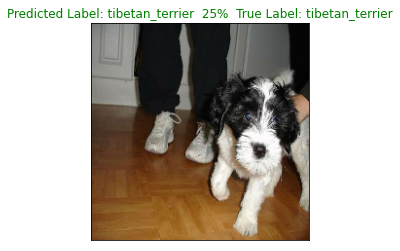

In [44]:
plot_pred(predictions, val_labels, val_images, 2)

In [45]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
    Plot the top 10 highest prediction confidences along with the truth label
    for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction labels 
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels = top_10_pred_labels,
             rotation = "vertical")
  
  # change color
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass


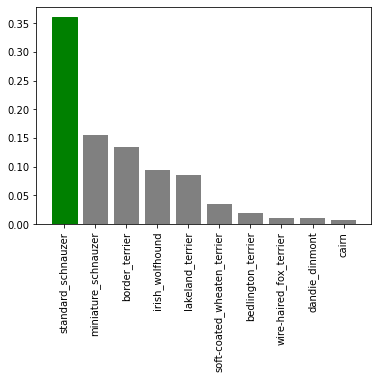

In [46]:
plot_pred_conf(predictions, val_labels, n=9)

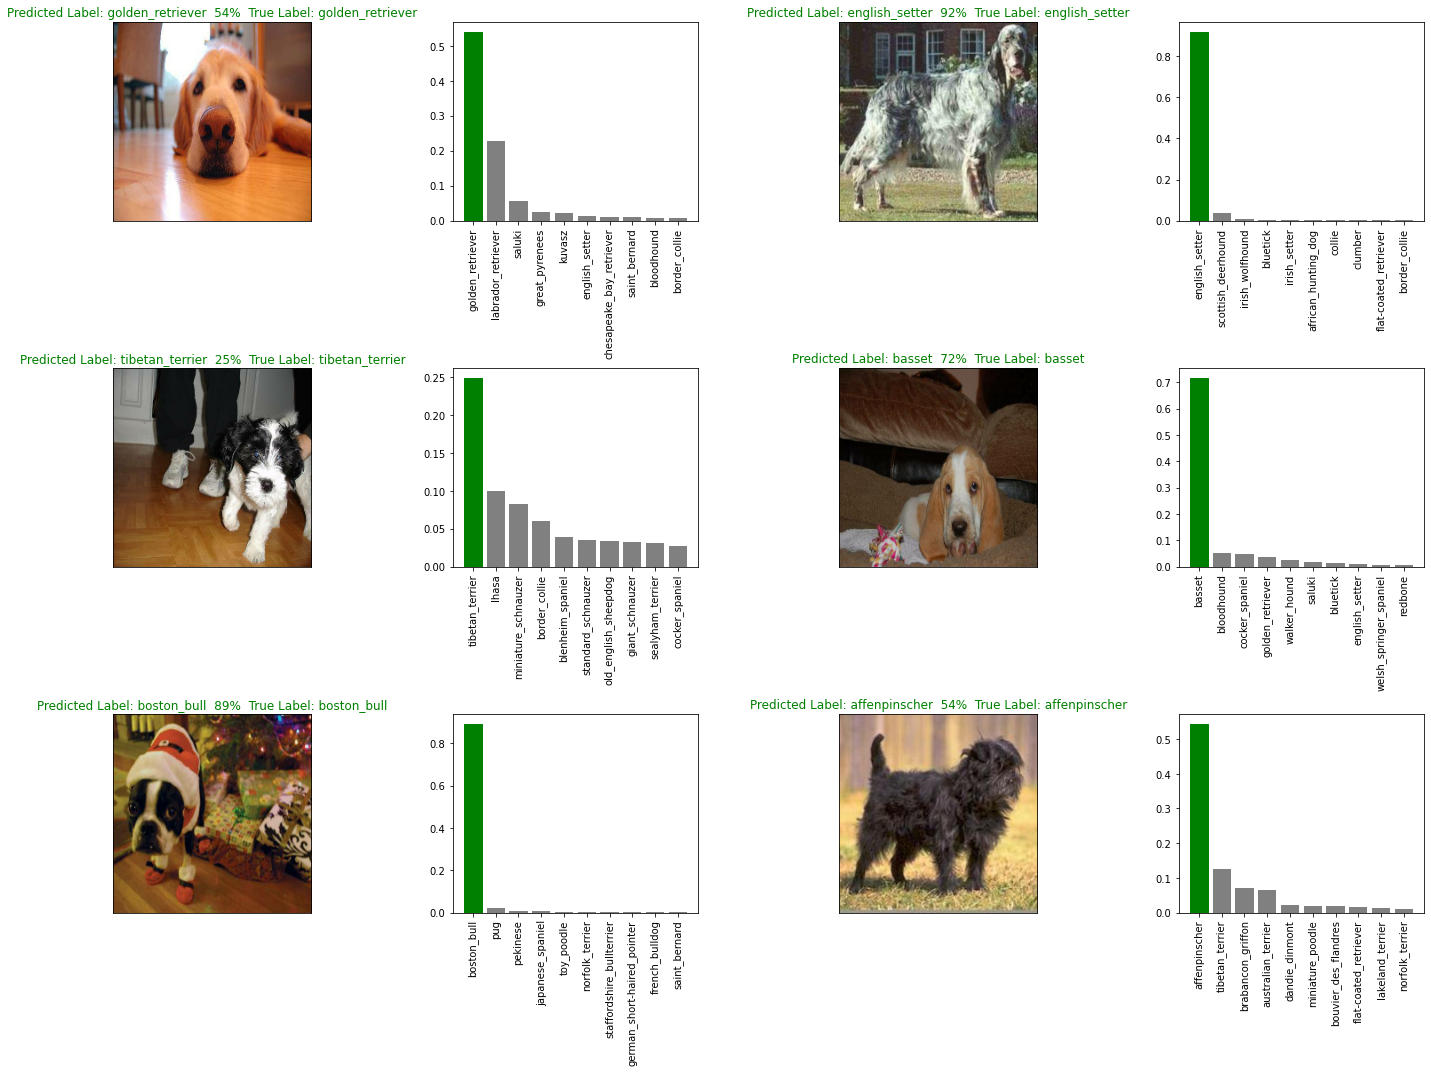

In [47]:
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10 * num_cols, 5 * num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2 * num_cols, 2*i+1)
  plot_pred(predictions, val_labels, val_images, n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(predictions, val_labels, n=i+i_multiplier)

plt.tight_layout(h_pad = 1.0)
plt.show() 


In [48]:
# save the trained model
def save_model(model, suffix=None):
  """
    Saves a given model in a models directory and appends a suffix (string).
  """
  model_dir = os.path.join("/content/drive/MyDrive/Data/models",
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  model_path = model_dir + "-" + suffix + ".h5"
  print(f"Saving model to : {model_path}...")
  model.save(model_path)
  return model_path


In [49]:
def load_model(model_path):
  """
    Loads a saved model from a specified path.
  """
  print(f"Loading saved model: {model_path}")
  model = tf.keras.models.load_model(model_path, custom_objects={"KerasLayer":hub.KerasLayer})

  return model

In [ ]:
# save the model trained on 1000 images
save_model(model, suffix="1000-images-mobilenet")

Saving model to : /content/drive/MyDrive/Data/models/20220416-151340-1000-images-mobilenet.h5...


'/content/drive/MyDrive/Data/models/20220416-151340-1000-images-mobilenet.h5'

## Training a model on full dataset

In [53]:
# create a data batch with the full dataset
full_data = create_data_batches(X, y)

Creating training data batches...


In [54]:
full_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [55]:
# create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [56]:
# create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

# no validation set when training on all the data, so we can't monitor 
# validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)


In [57]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=100,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 930s 3s/step - loss: 1.3361 - accuracy: 0.6708
Epoch 2/100
320/320 [==============================] - 51s 159ms/step - loss: 0.4001 - accuracy: 0.8823
Epoch 3/100
320/320 [==============================] - 51s 160ms/step - loss: 0.2404 - accuracy: 0.9353
Epoch 4/100
320/320 [==============================] - 54s 168ms/step - loss: 0.1555 - accuracy: 0.9638
Epoch 5/100
320/320 [==============================] - 51s 160ms/step - loss: 0.1046 - accuracy: 0.9804
Epoch 6/100
320/320 [==============================] - 53s 164ms/step - loss: 0.0781 - accuracy: 0.9865
Epoch 7/100
320/320 [==============================] - 53s 164ms/step - loss: 0.0580 - accuracy: 0.9917
Epoch 8/100
320/320 [==============================] - 55s 173ms/step - loss: 0.0467 - accuracy: 0.9948
Epoch 9/100
320/320 [==============================] - 56s 173ms/step - loss: 0.0366 - accuracy: 0.9968
Epoch 10/100
320/320 [==============================] - 57s 178ms/

In [58]:
save_model(full_model, suffix="full_image_set_mobilenet")

Saving model to : /content/drive/MyDrive/Data/models/20220417-174357-full_image_set_mobilenet.h5...


'/content/drive/MyDrive/Data/models/20220417-174357-full_image_set_mobilenet.h5'

## Make predictions on the test dataset

In [59]:
# load test image filenames
test_path = "/content/drive/MyDrive/Data/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/drive/MyDrive/Data/test/ea4a775ecbf81b2cd2967cc34ce4e52b.jpg',
 '/content/drive/MyDrive/Data/test/ea111bb38037c9922185a0e9513391d7.jpg',
 '/content/drive/MyDrive/Data/test/ea8669c09612478bfa202ae2fa101b13.jpg',
 '/content/drive/MyDrive/Data/test/ea1e945b924638c2059d7718b522d48f.jpg',
 '/content/drive/MyDrive/Data/test/ea23e5341ec5fc3f798ae527a4659d81.jpg',
 '/content/drive/MyDrive/Data/test/ea0a6a12e3f6f65e4f742b258a0ffe30.jpg',
 '/content/drive/MyDrive/Data/test/ea1993074afd8a51c571bb0f733a754d.jpg',
 '/content/drive/MyDrive/Data/test/eaacea894e9bdda125ae215081a0d9fc.jpg',
 '/content/drive/MyDrive/Data/test/ea280d6cb873df2eb683f0a5f13e3dce.jpg',
 '/content/drive/MyDrive/Data/test/ea3e496d0dd2b7c24ae8c9a0fea57060.jpg']

In [61]:
# create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [62]:
test_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [63]:
# make predictions on test data batch using the  full model
test_predictions = full_model.predict(test_data,
                                      verbose=1)

324/324 [==============================] - 1053s 3s/step


In [66]:
np.savetxt("/content/drive/MyDrive/Data/preds_array.csv", test_predictions, delimiter=",")

In [68]:
test_predictions.shape

(10357, 120)

In [70]:
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))


In [73]:
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]

In [74]:
preds_df["id"] = test_ids

In [75]:
preds_df[list(unique_breeds)] = test_predictions


In [76]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,ea4a775ecbf81b2cd2967cc34ce4e52b,2.105908e-07,1.106249e-04,5.003900e-09,5.718449e-09,6.330237e-10,2.484583e-08,2.131489e-08,3.515602e-10,1.271177e-10,...,4.827713e-07,3.183574e-09,3.958020e-08,1.242722e-08,6.019943e-09,1.502803e-10,1.233312e-12,5.468197e-06,3.273981e-08,4.133191e-09
1,ea111bb38037c9922185a0e9513391d7,3.241053e-08,2.732444e-11,3.434827e-10,1.166234e-13,4.518456e-07,3.762583e-13,3.695349e-10,5.174867e-10,1.295900e-08,...,1.160239e-09,1.117560e-11,1.857580e-12,2.856525e-10,6.659842e-12,3.203785e-10,9.999932e-01,1.612796e-11,1.895703e-08,3.193648e-08
2,ea8669c09612478bfa202ae2fa101b13,1.443243e-10,4.183819e-12,2.133752e-14,3.051150e-15,1.381615e-09,5.374410e-14,1.873728e-11,8.116592e-11,1.886747e-13,...,2.550095e-11,2.773206e-12,2.010180e-13,3.371542e-11,6.478840e-12,1.209613e-11,2.798471e-09,1.732189e-13,1.787048e-14,2.975492e-13
3,ea1e945b924638c2059d7718b522d48f,2.419512e-09,2.052132e-10,7.496376e-03,6.177097e-09,5.645556e-06,4.678944e-11,1.803068e-07,3.156639e-08,4.668265e-11,...,6.432595e-08,2.278018e-08,2.488513e-10,2.060829e-09,1.727123e-09,1.760174e-08,6.286690e-08,3.543409e-08,9.543422e-12,8.818183e-11
4,ea23e5341ec5fc3f798ae527a4659d81,3.583871e-08,5.204842e-08,1.527414e-08,1.510969e-09,5.267210e-03,6.647321e-07,2.596782e-08,2.571307e-07,3.614650e-06,...,2.114413e-06,6.954190e-08,1.247802e-07,4.404091e-04,1.471192e-06,1.050086e-07,1.200318e-06,7.791561e-06,2.057818e-10,2.474734e-09


In [78]:
preds_df.to_csv("/content/drive/MyDrive/Data/full_model_predictions.csv", index=False)